Importing necessary python files

In [65]:
#For data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.utils import resample

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt


#For Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Loading DataSet

In [2]:
data = pd.read_csv('/USERS/uSer/PYTHON/datasets/credit_card_fraud.csv')

Viewing basic data informations

In [10]:
#See what data is in the given dataset
data.head()

,Transaction_ID,Transaction_Amount,Transaction_Time,Transaction_Date,Merchant_Category,Merchant_Location,Payment_Type,Device_Type,Customer_Age,Customer_Gender,Customer_Account_Tenure,Customer_Income_Bracket,Customer_Country,Fraud_Flag
0,617962,2443.38,13,2024-03-05 03:21:00,Fuel,New York,Credit,Desktop,45.0,Male,15.13,Low,India,0
1,110796,4084.92,6,2023-03-18 22:35:00,Clothing,San Francisco,Prepaid,Mobile,69.0,Other,2.69,Low,Germany,0
2,988942,3108.85,10,2024-11-17 18:21:00,Fuel,San Francisco,Credit,Tablet,50.0,Male,1.69,High,India,0
3,152882,1579.51,0,2023-04-17 04:01:00,Electronics,Los Angeles,Credit,Mobile,27.0,Other,7.90,High,UK,0
4,669258,556.63,21,2024-04-09 18:17:00,Restaurants,New York,Credit,Mobile,75.0,Female,10.74,Medium,India,0


In [20]:
data['Payment_Type'].unique()

array(['Credit', 'Prepaid', 'Debit'], dtype=object)

In [3]:
#To view data column header and the type of data stored in them
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010000 entries, 0 to 1009999
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Transaction_ID           1010000 non-null  int64  
 1   Transaction_Amount       989809 non-null   float64
 2   Transaction_Time         1010000 non-null  int64  
 3   Transaction_Date         1010000 non-null  object 
 4   Merchant_Category        1010000 non-null  object 
 5   Merchant_Location        1010000 non-null  object 
 6   Payment_Type             1010000 non-null  object 
 7   Device_Type              1010000 non-null  object 
 8   Customer_Age             989823 non-null   float64
 9   Customer_Gender          1010000 non-null  object 
 10  Customer_Account_Tenure  1010000 non-null  float64
 11  Customer_Income_Bracket  989814 non-null   object 
 12  Customer_Country         1010000 non-null  object 
 13  Fraud_Flag               1010000 non-null 

In [4]:
#To view the number of null vlues in each columns
data.isnull().sum()

Transaction_ID                 0
Transaction_Amount         20191
Transaction_Time               0
Transaction_Date               0
Merchant_Category              0
Merchant_Location              0
Payment_Type                   0
Device_Type                    0
Customer_Age               20177
Customer_Gender                0
Customer_Account_Tenure        0
Customer_Income_Bracket    20186
Customer_Country               0
Fraud_Flag                     0
dtype: int64

There are null values or empty cells in 3 columns; Transaction_Amount, Customer_Age and Customer_Income_Bracket.
Here we instead of removing the rows with missing datas we are going to fill them in using the 'fillna()' function.

In [8]:
data['Merchant_Category'].unique()

array(['Fuel', 'Clothing', 'Electronics', 'Restaurants', 'Groceries',
       'Travel'], dtype=object)

In [9]:
#For Transaction_Amount, here the data is first being grouped by the category as the amount being spent may vary
# based on the categoty of the merchant similar will be done for Customer_Age and Customer_Income_Bracket.

data['Transaction_Amount'] = data['Transaction_Amount'].fillna(
    data.groupby('Merchant_Category')['Transaction_Amount'].transform('median')
)

data['Customer_Age'] = data['Customer_Age'].fillna(
    data.groupby('Merchant_Category')['Customer_Age'].transform('median')
)

data['Customer_Income_Bracket'] = data['Customer_Income_Bracket'].fillna(
    data.groupby('Merchant_Category')['Customer_Income_Bracket'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

In [12]:
#To view if any null values remain
data.isnull().sum()

Transaction_ID             0
Transaction_Amount         0
Transaction_Time           0
Transaction_Date           0
Merchant_Category          0
Merchant_Location          0
Payment_Type               0
Device_Type                0
Customer_Age               0
Customer_Gender            0
Customer_Account_Tenure    0
Customer_Income_Bracket    0
Customer_Country           0
Fraud_Flag                 0
dtype: int64

In [34]:
#To check for duplicate datas
# Count total duplicates
total_duplicates = data.duplicated().sum()
print(f'Total duplicate rows: {total_duplicates}')

Total duplicate rows: 9778


In [36]:
#There are a total of 9778 duplicate datas in the given dataset. We need to remove them before proceeding.

data = data.drop_duplicates(keep='last')

total_duplicates = data.duplicated().sum()
print(f'Total duplicate rows: {total_duplicates}')

Total duplicate rows: 0


In [69]:
#Separateing date and time

# Step 1: Convert to datetime if it's not already
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'], errors='coerce')

# Step 2: Split into separate Date and Time columns
data['Date'] = data['Transaction_Date'].dt.date
data['Time'] = data['Transaction_Date'].dt.time

In [71]:
data.drop(['Transaction_Time', 'Transaction_Date'], axis=1, inplace=True)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000222 entries, 0 to 1009999
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Transaction_ID           1000222 non-null  int64  
 1   Transaction_Amount       1000222 non-null  float64
 2   Merchant_Category        1000222 non-null  int32  
 3   Merchant_Location        1000222 non-null  int32  
 4   Payment_Type             1000222 non-null  int32  
 5   Device_Type              1000222 non-null  int32  
 6   Customer_Age             1000222 non-null  float64
 7   Customer_Gender          1000222 non-null  int32  
 8   Customer_Account_Tenure  1000222 non-null  float64
 9   Customer_Income_Bracket  1000222 non-null  int32  
 10  Customer_Country         1000222 non-null  int32  
 11  Fraud_Flag               1000222 non-null  int64  
 12  Hour                     1000222 non-null  int32  
 13  Day                      1000222 non-null  int3

DATA VISUALIZATION

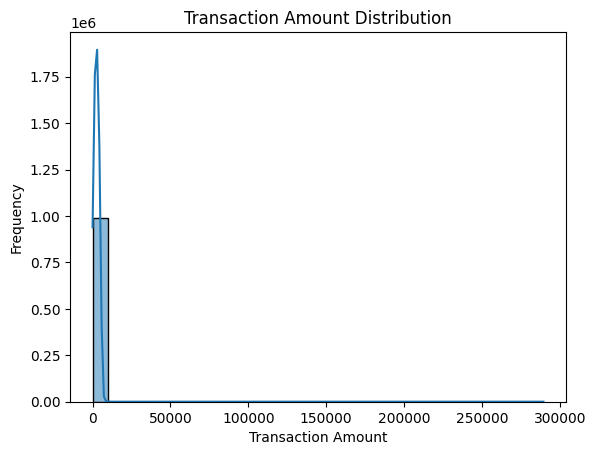

In [37]:
#Transaction Amount Distribution

sns.histplot(data['Transaction_Amount'], bins=30, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


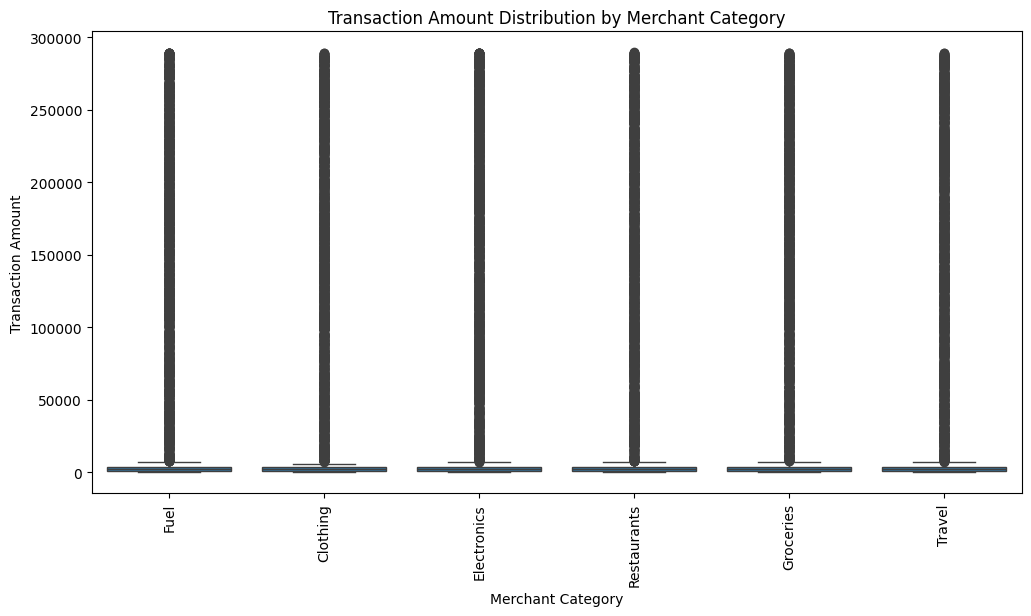

In [38]:
# Box plot for Transaction_Amount by Merchant_Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Merchant_Category', y='Transaction_Amount', data=data)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Transaction Amount Distribution by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Transaction Amount')
plt.show()

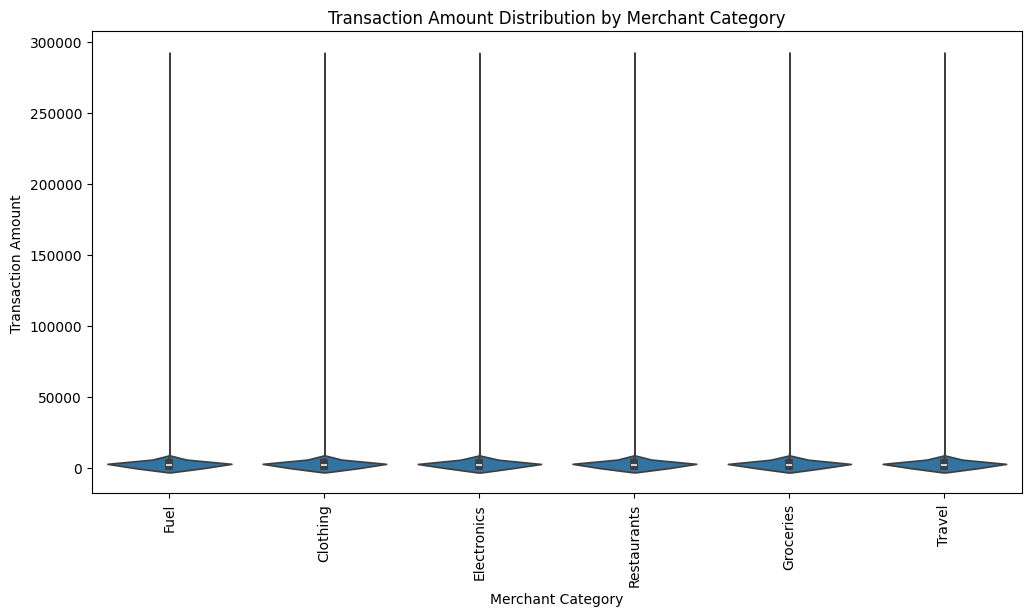

In [39]:
# Violin plot for Transaction_Amount by Merchant_Category
plt.figure(figsize=(12, 6))
sns.violinplot(x='Merchant_Category', y='Transaction_Amount', data=data)
plt.xticks(rotation=90)
plt.title('Transaction Amount Distribution by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Transaction Amount')
plt.show()

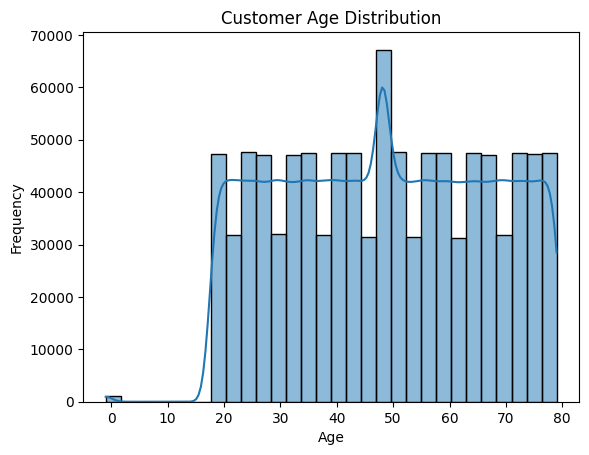

In [40]:
#Customer Age Distribution
sns.histplot(data['Customer_Age'], bins=30, kde=True)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

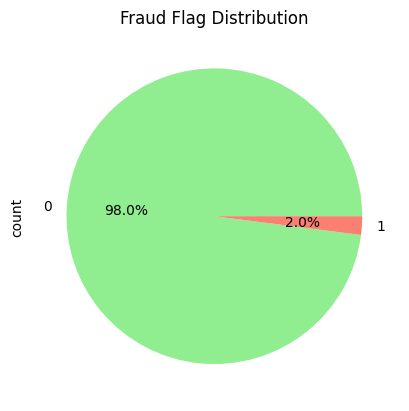

In [41]:
#Fraud Flag Distribution
data['Fraud_Flag'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Fraud Flag Distribution')
plt.show()

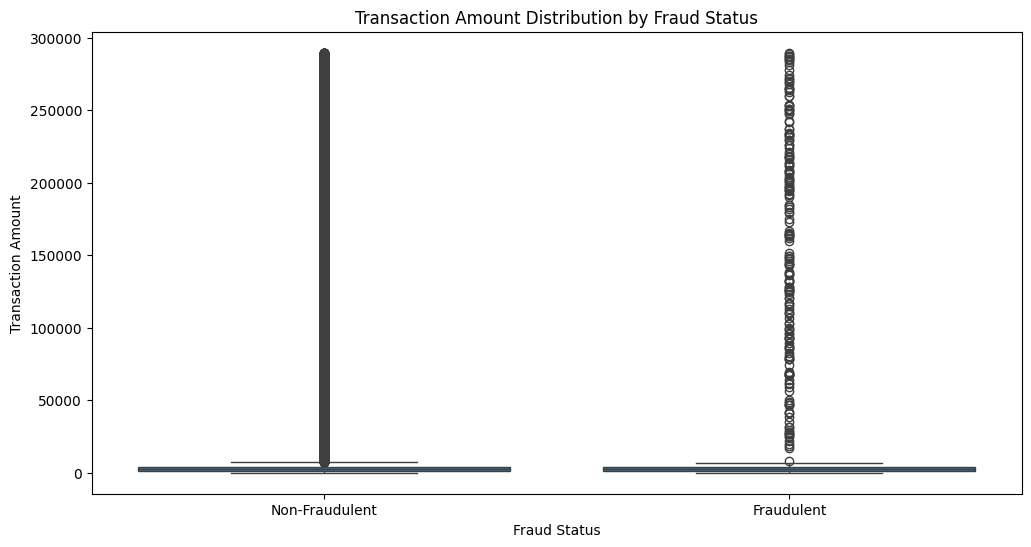

In [42]:
#Fraud Distribution by Transaction Amount
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fraud_Flag', y='Transaction_Amount', data=data)
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.title('Transaction Amount Distribution by Fraud Status')
plt.ylabel('Transaction Amount')
plt.xlabel('Fraud Status')
plt.show()

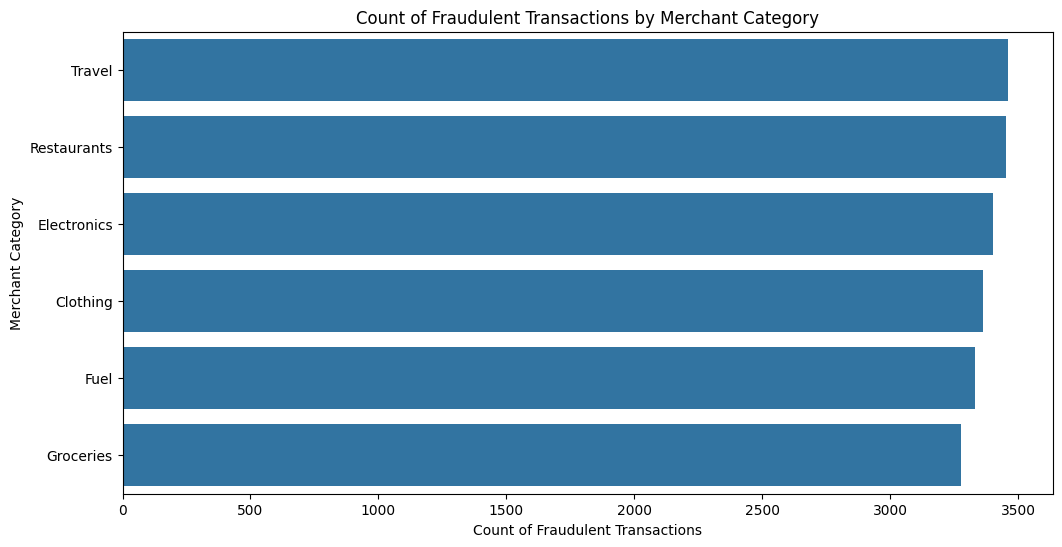

In [43]:
#Fraud Count by Merchant Category
plt.figure(figsize=(12, 6))
fraud_counts = data[data['Fraud_Flag'] == 1].groupby('Merchant_Category').size().reset_index(name='Counts')
sns.barplot(x='Counts', y='Merchant_Category', data=fraud_counts.sort_values('Counts', ascending=False))
plt.title('Count of Fraudulent Transactions by Merchant Category')
plt.xlabel('Count of Fraudulent Transactions')
plt.ylabel('Merchant Category')
plt.show()

Machine Learning

In [58]:
Fraud = data[data['Fraud_Flag']==1].shape[0]

Not_Fraud = data[data['Fraud_Flag']==0].shape[0]

In [60]:
print(f'The are {Fraud} transactions that heve been marked as fraud and {Not_Fraud} marked as not fraud in the given data')

The are 20286 transactions that heve been marked as fraud and 979936 marked as not fraud in the given data


In the given data set only 2% of data has been marked as Fraud transaction as such we need to manipulate the data 
being given for machine learning purpose so as not to skew the final result.

In [73]:
# separate categorical and numeric datas

cat_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [74]:
le = LabelEncoder()
# Applying label encoding to each of the categorical columns
for col in cat_columns:
     data[col] = le.fit_transform(data[col])
# Now, the dataset should be preprocessed and ready for feature 
#selection and modeling
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000222 entries, 0 to 1009999
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Transaction_ID           1000222 non-null  int64  
 1   Transaction_Amount       1000222 non-null  float64
 2   Merchant_Category        1000222 non-null  int32  
 3   Merchant_Location        1000222 non-null  int32  
 4   Payment_Type             1000222 non-null  int32  
 5   Device_Type              1000222 non-null  int32  
 6   Customer_Age             1000222 non-null  float64
 7   Customer_Gender          1000222 non-null  int32  
 8   Customer_Account_Tenure  1000222 non-null  float64
 9   Customer_Income_Bracket  1000222 non-null  int32  
 10  Customer_Country         1000222 non-null  int32  
 11  Fraud_Flag               1000222 non-null  int64  
 12  Hour                     1000222 non-null  int32  
 13  Day                      1000222 non-null  int3

In [75]:
#separating Fraud and Not  Fraud transaction

fraud_txn = data[data['Fraud_Flag']==1]
not_fraud_txn = data[data['Fraud_Flag']==0]

In [76]:
# Split the dataset into features and target variable
X = data.drop('Fraud_Flag', axis=1)
y = data['Fraud_Flag']

In [77]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [88]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [79]:
# Train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95    293981
           1       0.02      0.07      0.03      6086

    accuracy                           0.91    300067
   macro avg       0.50      0.50      0.49    300067
weighted avg       0.96      0.91      0.93    300067



In [90]:
#Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [81]:
accuracy

0.9114297806823143

In [82]:
conf_matrix

array([[273088,  20893],
       [  5684,    402]], dtype=int64)

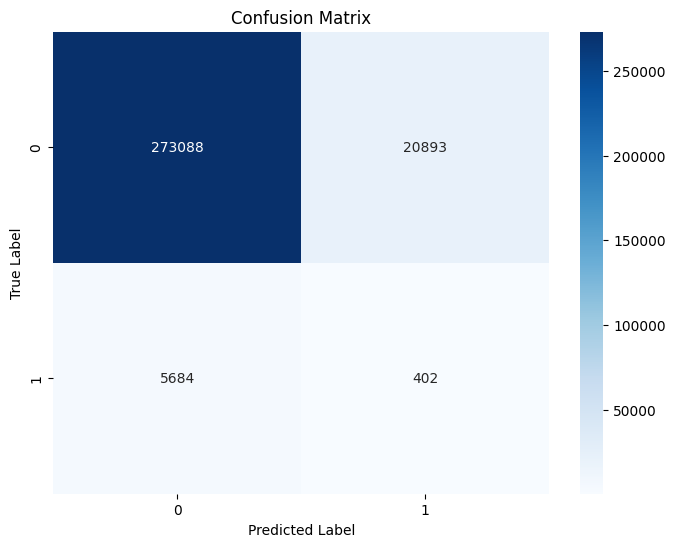

In [83]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Random Forest

In [85]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
RandomForestClassifier(random_state=42)

RandomForestClassifier(random_state=42)

In [91]:
# Predict the target labels for the test set
y_pred = rf_model.predict(X_test)
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.9105166512812138


Confusion Matrix:
[[272761  21220]
 [  5631    455]]


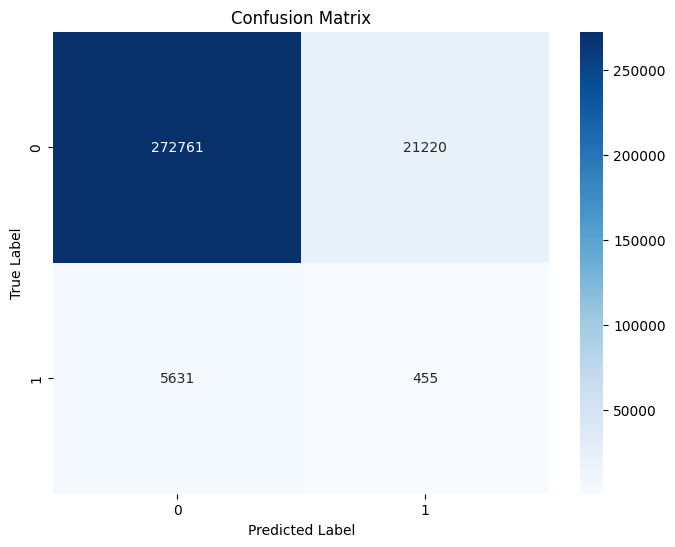

In [92]:
conf_matrix_rf = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

LogisticRegression

In [93]:
model_lr = LogisticRegression()
model_lr.fit(X_train_resampled, y_train_resampled)

C:\Anaconda\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [94]:
# Predict on test data
y_pred = model_lr.predict(X_test)

Accuracy: 0.6562067804856915
Confusion Matrix:
 [[194861  99120]
 [  4041   2045]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.66      0.79    293981
           1       0.02      0.34      0.04      6086

    accuracy                           0.66    300067
   macro avg       0.50      0.50      0.41    300067
weighted avg       0.96      0.66      0.78    300067

ROC-AUC: 0.49942622085237565


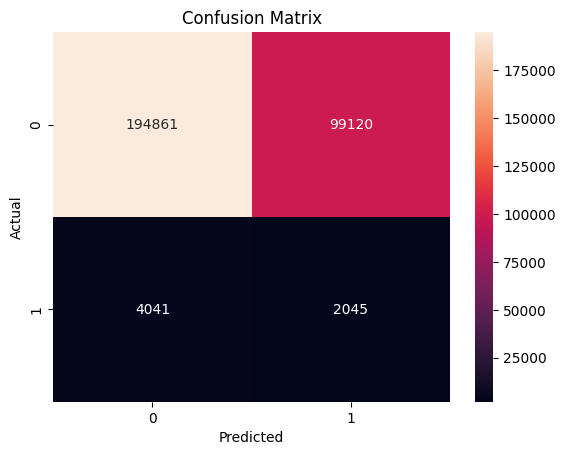

In [95]:
# Model Performance Metrics
accuracy_lr = accuracy_score(y_test, y_pred)
conf_matrix_lr= confusion_matrix(y_test, y_pred)
class_report_lr = classification_report(y_test, y_pred)
roc_auc_lr = roc_auc_score(y_test, y_pred)

# Print Metrics
print(f'Accuracy: {accuracy_lr}')
print('Confusion Matrix:\n', conf_matrix_lr)
print('Classification Report:\n', class_report_lr)
print(f'ROC-AUC: {roc_auc_lr}')

# Plot confusion matrix
sns.heatmap(conf_matrix_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Undersample majority class
majority_downsampled = not_fraud_txn.sample(50000)

# Combine minority class with downsampled majority class
train_data_balanced = pd.concat([majority_downsampled, fraud_txn])

# Separate features and target variable
X_train_balanced = train_data_balanced.drop('Fraud_Flag', axis=1)
y_train_balanced = train_data_balanced['Fraud_Flag']

In [107]:
# Train-test split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_train_balanced, y_train_balanced, test_size=0.3, random_state=42, stratify=y_train_balanced)

In [108]:
# Train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_d, y_train_d)

# Make predictions
y_pred_d = model.predict(X_test_d)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test_d, y_pred_d))


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70     15000
           1       0.29      0.31      0.30      6086

    accuracy                           0.58     21086
   macro avg       0.50      0.50      0.50     21086
weighted avg       0.59      0.58      0.59     21086

